**Change CRS of Annual Crop Inventories**

This chunck of code transforms CRS of the ACI tiffs for years 2013-2023 to match that of the EVIIRS

In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

#define dictionaries 
aci_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/annual-crop-inventory/'
output_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/reprojected-aci/'
eviirs_zip_path = 'C:/NSCC/winter/ImageAnalytics/Assignment4/eviirs-ndvi-20231203.zip'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Open the eVIIRS dataset to get its CRS
with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    target_crs = eviirs.crs

# Loop through each year to reproject ACI datasets
for year in years:
    aci_zip_path = os.path.join(aci_directory, f'aci_{year}_pe.zip')
    output_path = os.path.join(output_directory, f'reprojected_aci_{year}_pe.tif')

    # Open the ACI dataset
    with rasterio.open(f'zip+file://{aci_zip_path}!/aci_{year}_pe.tif') as aci:
        transform, width, height = calculate_default_transform(
            aci.crs, target_crs, aci.width, aci.height, *aci.bounds)
        
        # Define the metadata 
        meta = aci.meta.copy()
        meta.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # reproject and write each band
        with rasterio.open(output_path, 'w', **meta) as dst:
            for i in range(1, aci.count + 1):
                reproject(
                    source=rasterio.band(aci, i),
                    destination=rasterio.band(dst, i),
                    src_transform=aci.transform,
                    src_crs=aci.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)


print(dst.crs) 
print(eviirs.crs)  


**Crop ACI tiffs to match EVIIRS**

This code crops the ACI tiffs to match those of EVIIRS

In [ ]:
import os
import rasterio
import shapely
from rasterio.mask import mask
from shapely.geometry import box
import json

aci_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/annual-crop-inventory/'
output_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/reprojected-aci/'
cropped_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/cropped-aci/'
eviirs_zip_path = 'C:/NSCC/winter/ImageAnalytics/Assignment4/eviirs-ndvi-20231203.zip'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


# Open the eVIIRS dataset
with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    # Create a bounding box polygon from the eVIIRS dataset
    bbox = box(*eviirs.bounds)
    bbox_geojson = json.loads(json.dumps(shapely.geometry.mapping(bbox)))

# Loop through each year to crop the reprojected ACI datasets
for year in years:
    input_path = os.path.join(output_directory, f'reprojected_aci_{year}_pe.tif')
    output_path = os.path.join(cropped_directory, f'cropped_aci_{year}_pe.tif')
    
    # Open the reprojected ACI dataset
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, [bbox_geojson], crop=True)
        out_meta = src.meta.copy()
        
        # Update the metadata
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        
        # Write the cropped image
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


**Calculate the proportion of area cropped with potatoes within each pixel**

This chuck of code calculates the porportion of potato crops per pixel. The workflow used first initializes a new array potato_proportion to later use to store the proportion of potato crops in each pixel. It then iterates over each pixel in the eVIIRS raster, defining coordinates using the transformation to create a box for each pixel and converts it into GeoJSON format. Then it uses this geometry to mask the ACI raster, cropping the ACI data to the extent of the current pixel. Then variables are defined for counts of the total number of pixels in the masked ACI raster and the number that correspond to potato fields (classified with the value 177). Then the code calculates the proportion of potato pixels to the total number of pixels in the masked area by using, proportion = (potato_pixels / total_pixels) * 100. Lastly it exports the proportion in the potato_proportion array to raster.


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping

# Updated directory paths
aci_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/annual-crop-inventory'
cropped_aci_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/cropped-aci' 
raster_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4'
eviirs_zip_path = 'C:/NSCC/winter/ImageAnalytics/Assignment4/eviirs-ndvi-20231203.zip'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Open the eVIIRS image to get its dimensions, pixel size, and CRS
with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif', 'r') as eviirs:
    eviirs_transform = eviirs.transform
    eviirs_width = eviirs.width
    eviirs_height = eviirs.height

# Loop through the specified list of years
for current_year in years:
    aci_file_path = os.path.join(cropped_aci_directory, f'cropped_aci_{current_year}_pe.tif')
    
    
    with rasterio.open(aci_file_path, 'r') as aci:
    
        potato_proportion = np.zeros((eviirs_height, eviirs_width), dtype=np.float32)
        for row in range(eviirs_height):
            for col in range(eviirs_width):
                x, y = eviirs_transform *(col, row) 
                pixel_geom = box(x, y, x + eviirs_transform.a, y + eviirs_transform.e)
                geojson_geom = mapping(pixel_geom)

                # Use the geometry to mask the ACI dataset
                try:
                    out_image, out_transform = mask(aci, [geojson_geom], crop=True)
                    potato_pixels = np.count_nonzero(out_image == 177)
                    total_pixels = out_image.size 

                    if total_pixels > 0:
                        proportion = (potato_pixels / total_pixels) * 100
                        potato_proportion[row, col] = max(proportion, 0)  
                    else:
                        potato_proportion[row, col] = 0  
                except ValueError:
                    potato_proportion[row, col] = 0  

        # output raster file name
        raster_file_name = os.path.join(raster_directory, f'potato_raster_{current_year}.tif')

        # write the proportion of potato fields to the new raster dataset
        with rasterio.open(
            raster_file_name,
            'w',
            driver='GTiff',
            width=eviirs_width,
            height=eviirs_height,
            count=1,
            dtype='float32',
            crs=eviirs.crs,
            transform=eviirs_transform
        ) as potato_raster:
            potato_raster.write(potato_proportion, 1)


**Calcualte NDVI**

This chuck of code calculates integrated NDVI profiles from satellite imagery and correlate these with potato yield data soruced from a Statistic Canada database First it calculates the proportion of areas meeting a potato crop threshold of 75% in the potato_raster data and then extracts the NDVI values corresponding to these areas. For each year, it finds all days of data and integrates the NDVI values over time and pairs the result with potato yield data from the stats Can database. The data collection aims to establish a potential correlation between NDVI and potato yields. Lastly it converts everything into numpy arrays for linear regression







In [1]:
import os
import numpy as np
import rasterio
import glob
from scipy.integrate import trapz
import sqlite3

aci_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/annual-crop-inventory'
cropped_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/cropped-aci'
eviirs_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4/eviirs-ndvi-20231203'
raster_directory = 'C:/NSCC/winter/ImageAnalytics/Assignment4'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# define potato proportion threshold
threshold = 75

# initialize empty lists to store NDVI and yield values
integrated_ndvi_values = []
average_yield_values = []

# function to find all eVIIRS GeoTIFF files for a given year
def find_eviirs_files(year):
    pattern = f'GN_eVSH_NDVI.{year}*.tif'
    file_paths = glob.glob(os.path.join(eviirs_directory, pattern))
    file_paths = [path for path in file_paths if 'QUAL' not in os.path.basename(path)]
    return file_paths

# function to calculate integrated NDVI profile for all files found for a given year
def calculate_integrated_ndvi_profile(crop_filename, year, threshold):
    integrated_ndvi_profile = []
    day_numbers = []  

    # find all eVIIRS files for the year
    file_paths = find_eviirs_files(year)
    for file_path in file_paths:
        day_numbers.append(int(file_path.split('.')[2][4:7]))  
        try:
            with rasterio.open(file_path) as eviirs_ndvi:
                with rasterio.open(crop_filename, 'r') as crop_proportion:
                    ndvi_data = eviirs_ndvi.read(1)
                    crop_proportion_mask = crop_proportion.read(1) >= threshold
                    ndvi_data = ndvi_data * crop_proportion_mask
                    mean_ndvi = np.mean(ndvi_data[ndvi_data != 0]) / 10000  
                    integrated_ndvi_profile.append(mean_ndvi)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # integrate the NDVI profile using the day numbers
    integrated_ndvi = trapz(integrated_ndvi_profile, day_numbers)
    integrated_ndvi_values.append(integrated_ndvi)
    print(year, integrated_ndvi) 

    return integrated_ndvi


# SQLite database connection
conn = sqlite3.connect(r'C:\nscc\winter\ImageAnalytics\Assignment4\statistics-canada\statistics-canada.db')
cursor = conn.cursor()

# loop through each year, processing the corresponding NDVI and crop proportion data
for current_year in years:
    aci_file_path = os.path.join(raster_directory, f'potato_raster_{current_year}.tif')
    integrated_ndvi = calculate_integrated_ndvi_profile(aci_file_path, current_year, threshold)

    # find yield data for the current year from the SQLite database
    cursor.execute("""
        SELECT year, name, average_yield
        FROM potato_production 
        WHERE year = ? AND name = 'Prince Edward Island'
        ORDER BY year
    """, (current_year,))

    result = cursor.fetchone()
    if result:
        year, name, average_yield = result
        print(f"Year: {year}, Average Yield: {average_yield}")
        average_yield_values.append(average_yield)
    else:
        print(f"No data found for year {current_year}")

# close the SQLite connection
conn.close()

# convert lists to Numpy arrays for potential future analysis
integrated_ndvi_array = np.array(integrated_ndvi_values)
average_yield_array = np.array(average_yield_values)


2013 98.8095625
Year: 2013, Average Yield: 301.7
2014 91.15537499999999
Year: 2014, Average Yield: 298.0
2015 93.11836666666667
Year: 2015, Average Yield: 291.3
2016 93.12795
Year: 2016, Average Yield: 296.7
2017 97.49609000000001
Year: 2017, Average Yield: 294.0
2018 90.26389999999999
Year: 2018, Average Yield: 285.4
2019 95.88405
Year: 2019, Average Yield: 289.3
2020 87.52264999999998
Year: 2020, Average Yield: 251.5
2021 100.7284125
Year: 2021, Average Yield: 322.0
2022 102.32772
Year: 2022, Average Yield: 334.0
2023 92.8386
Year: 2023, Average Yield: 311.0


**Create a Linear Model**

This model shows a reasonable linear relationship between yield and NDVI, indicating that NDVI is a good variable to predcit potato yield. The R squared value for NDVI is 0.65 indicating that it explains 65% of the difference in yield, therefore there are other variables that could be assessed and explored as to their influence on potato yield.  A better predictive model could be made by including more variables that influence potato growth. Canada offers a wide array of open data that could be used to predict potato yields beyond NDVI. Variables such as:

1. Soil Quality
- soil moisture levels
- soil type
- nutrients
- pH levels 
2. Weather Data:
- seasonal temperature variations
- precipitation
- sunlight
- dates of first and last frost/ growing season






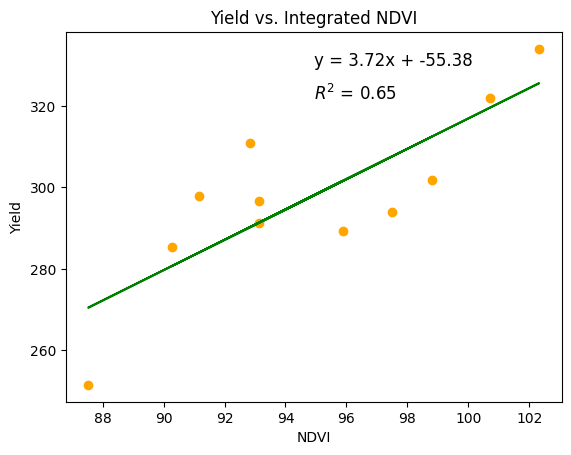

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Convert back to numpy array
ndvi = np.array(integrated_ndvi_array)
Potato_yield = np.array(average_yield_array)


if ndvi.size > 1 and Potato_yield.size > 1:
    
    slope, intercept, r_value, p_value, std_err = linregress(ndvi, Potato_yield)

   
    def predict(x):
        return slope * x + intercept
    
    fit_line = predict(ndvi)

    # Plotting
    plt.scatter(ndvi, Potato_yield, color='orange')  
    plt.plot(ndvi, fit_line, color='green') 
    plt.ylabel('Yield')
    plt.xlabel('NDVI')
    plt.title('Yield vs. Integrated NDVI')
    plt.text(max(ndvi) - 0.5*(max(ndvi) - min(ndvi)), max(Potato_yield) - 0.05*(max(Potato_yield) - min(Potato_yield)), f'y = {slope:.2f}x + {intercept:.2f}', fontsize=12)
    plt.text(max(ndvi) - 0.5*(max(ndvi) - min(ndvi)), max(Potato_yield) - 0.15*(max(Potato_yield) - min(Potato_yield)), f'$R^2$ = {r_value**2:.2f}', fontsize=12)
else:
    print("Error: Not enough data points for regression analysis.")
